In [1]:
import os
import numpy as np
import tensorflow as tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras import backend as K
import cv2
from keras.preprocessing import image
import random

In [2]:
# Setting Up Paths for Google Colab
# You should adjust this path to where your dataset is located in Google Drive
BASE_PATH = './data/'  # Change this to your dataset location
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Val')
TEST_PATH = os.path.join(BASE_PATH, 'Test')
WEIGHTS_PATH = os.path.join(BASE_PATH, 'resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [3]:
# Ensure the paths exist (optional, but good practice)
print("Train Path:", TRAIN_PATH)
print("Validation Path:", VAL_PATH)
print("Test Path:", TEST_PATH)
print("Weights Path:", WEIGHTS_PATH)

Train Path: ./data/Train
Validation Path: ./data/Val
Test Path: ./data/Test
Weights Path: ./data/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
# Data Augmentation and Generators
IMG_SIZE = 224
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2416 images belonging to 3 classes.
Found 193 images belonging to 3 classes.
Found 193 images belonging to 3 classes.


In [5]:
print("Training Data:")
print("Class Indices:", train_generator.class_indices)
print("Class Labels (in order):", train_generator.classes)
print("Number of samples per class:", {k: list(train_generator.classes).count(v) for k, v in train_generator.class_indices.items()})
print("Total number of training samples:", train_generator.samples)
print("-" * 30)
print("Validation Data:")
print("Class Indices:", validation_generator.class_indices)
print("Class Labels (in order):", validation_generator.classes)
print("Number of samples per class:", {k: list(validation_generator.classes).count(v) for k, v in validation_generator.class_indices.items()})
print("Total number of validation samples:", validation_generator.samples)
print("-" * 30)
print("Test Data:")
print("Class Indices:", test_generator.class_indices)
print("Class Labels (in order):", test_generator.classes)
print("Number of samples per class:", {k: list(test_generator.classes).count(v) for k, v in test_generator.class_indices.items()})
print("Total number of test samples:", test_generator.samples)

Training Data:
Class Indices: {'Bird': 0, 'Drone': 1, 'Others': 2}
Class Labels (in order): [0 0 0 ... 2 2 2]
Number of samples per class: {'Bird': 800, 'Drone': 799, 'Others': 817}
Total number of training samples: 2416
------------------------------
Validation Data:
Class Indices: {'Bird': 0, 'Drone': 1, 'Others': 2}
Class Labels (in order): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
Number of samples per class: {'Bird': 50, 'Drone': 60, 'Others': 83}
Total number of validation samples: 193
------------------------------
Test Data:
Class Indices: {'Bird': 0, 'Drone': 1, 'Others': 2}
Class Labels (in order): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [6]:
# Compute Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)
print("Class Indices:", train_generator.class_indices)

Class Weights: {0: np.float64(1.0066666666666666), 1: np.float64(1.0079265748852733), 2: np.float64(0.9857201142390861)}
Class Indices: {'Bird': 0, 'Drone': 1, 'Others': 2}


In [7]:
# Load, Customize, and Train ResNet50V2 Model
base_model = ResNet50V2(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# Load weights from the specified path
base_model.load_weights(WEIGHTS_PATH)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Changed output units to 3
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # You can adjust the number of epochs
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 888s 5s/step - accuracy: 0.6676 - loss: 0.7820 - val_accuracy: 0.7306 - val_loss: 0.8016
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 763s 5s/step - accuracy: 0.8357 - loss: 0.4317 - val_accuracy: 0.6736 - val_loss: 1.2285
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 772s 5s/step - accuracy: 0.8696 - loss: 0.3205 - val_accuracy: 0.8860 - val_loss: 0.4601
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 750s 5s/step - accuracy: 0.8945 - loss: 0.2811 - val_accuracy: 0.8394 - val_loss: 0.5962
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 752s 5s/step - accuracy: 0.9089 - loss: 0.2729 - val_accuracy: 0.8601 - val_loss: 0.4546
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 744s 5s/step - accuracy: 0.9127 - loss: 0.2479 - val_accuracy: 0.8601 - val_loss: 0.4823
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 768s 5s/step - accuracy: 0.9197 - loss: 0.2237 - val_accuracy: 0.7461 - val_loss: 0.9809
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 761s 5s/step - accuracy: 0.9296 - loss: 0.2074 - val_accu

In [10]:
# Model Evaluation
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8446 - loss: 0.7342
Test accuracy: 0.8446


13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step


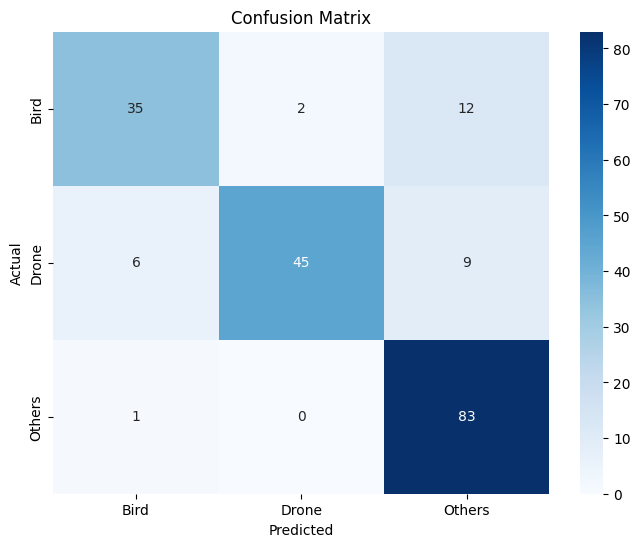

Classification Report:
               precision    recall  f1-score   support

        Bird       0.83      0.71      0.77        49
       Drone       0.96      0.75      0.84        60
      Others       0.80      0.99      0.88        84

    accuracy                           0.84       193
   macro avg       0.86      0.82      0.83       193
weighted avg       0.86      0.84      0.84       193

Precision: 0.8566
Recall: 0.8446
F1-Score: 0.8411


In [11]:
# Confusion Matrix and Classification Report
test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
target_names = list(test_generator.class_indices.keys())
classification_report_str = classification_report(test_labels, predicted_classes, target_names=target_names)
print("Classification Report:\n", classification_report_str)
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


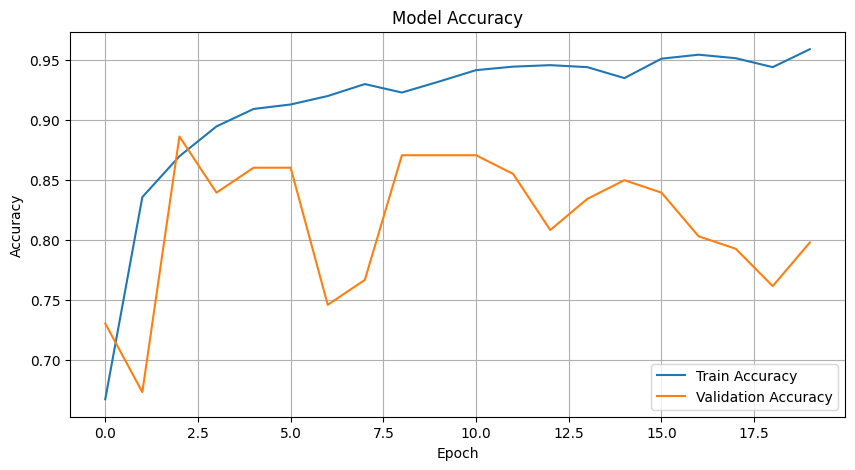

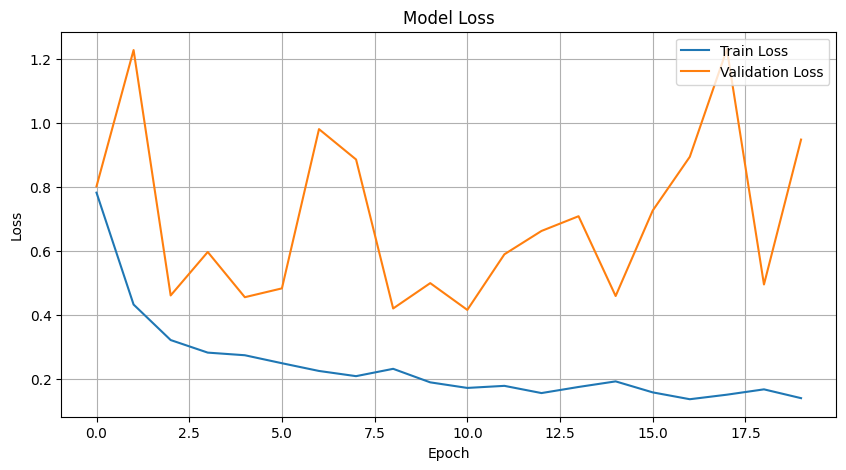

In [12]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [13]:
# Saving the Trained Model
model.save('classifcation_model.h5') # Saving in the recommended .keras format

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
[[8.378255e-10 4.758253e-09 1.000000e+00]]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
[[0.99682105 0.00198761 0.00119134]]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[[0.21272841 0.00973865 0.7775329 ]]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
[[9.9994993e-01 5.0008195e-05 5.6394316e-12]]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
[[1.9879879e-29 2.9584138e-28 1.0000000e+00]]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
[[3.114707e-15 1.000000e+00 5.737260e-13]]
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
[[2.4948092e-06 1.2420978e-06 9.9999630e-01]]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
[[9.9924576e-01 4.6929941e-04 2.8496090e-04]]
0


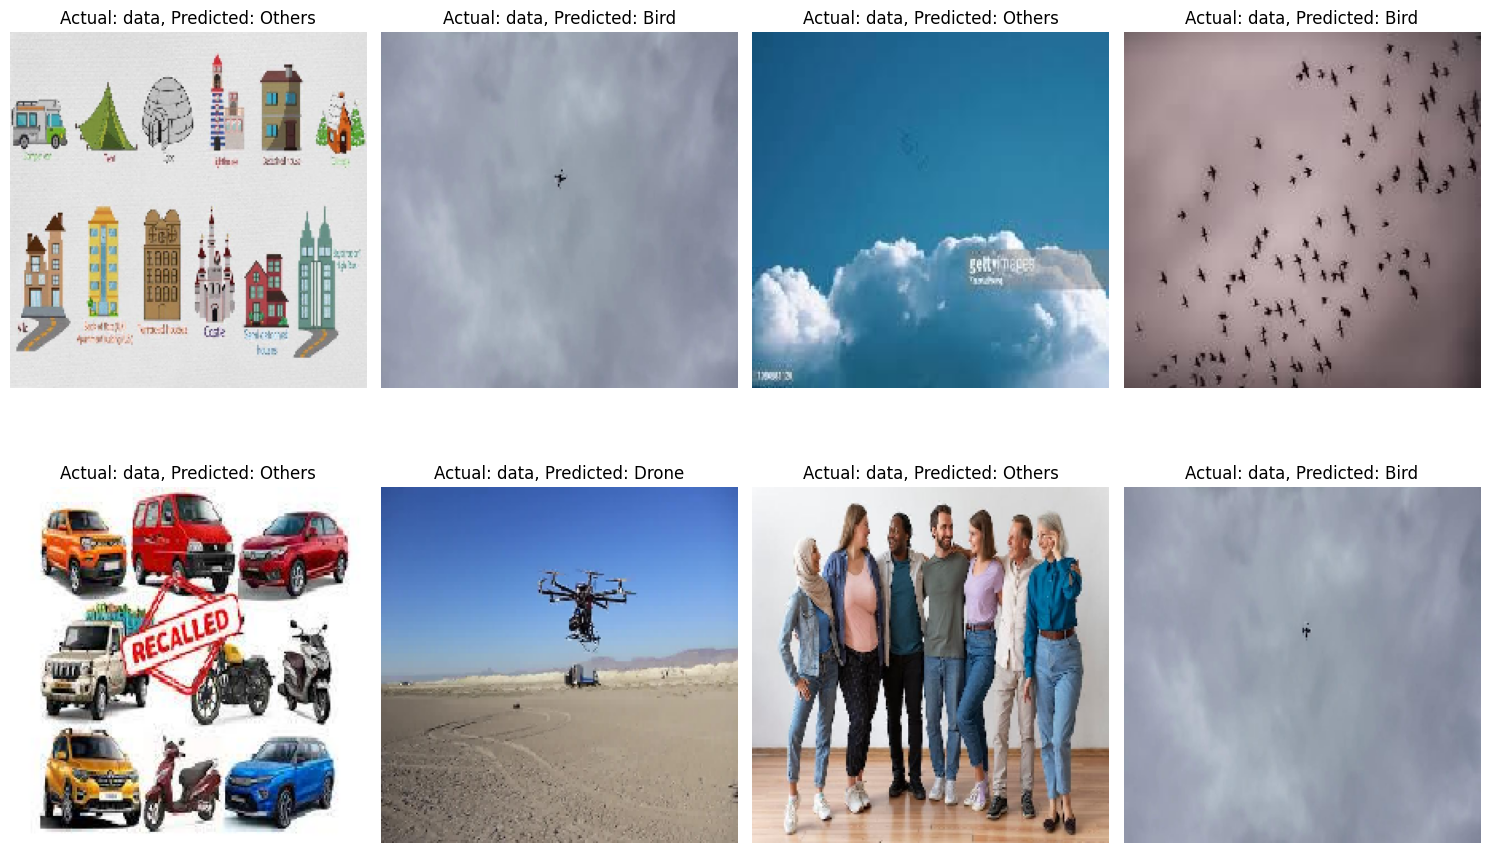

In [14]:
# Visualization of Random Test Images
test_dir = TEST_PATH
class_names = list(test_generator.class_indices.keys())
image_paths = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        image_files = os.listdir(class_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(class_dir, image_file))
random_images = random.sample(image_paths, 8)
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(random_images):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    class_label = np.argmax(prediction, axis=1)[0]
    actual_class = img_path.split('/')[-2]
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Actual: {actual_class}, Predicted: {class_names[class_label]}')
    print(prediction)
    print(class_label)
plt.tight_layout()
plt.show()

c:\Users\kiran\Desktop\AeroHawk\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


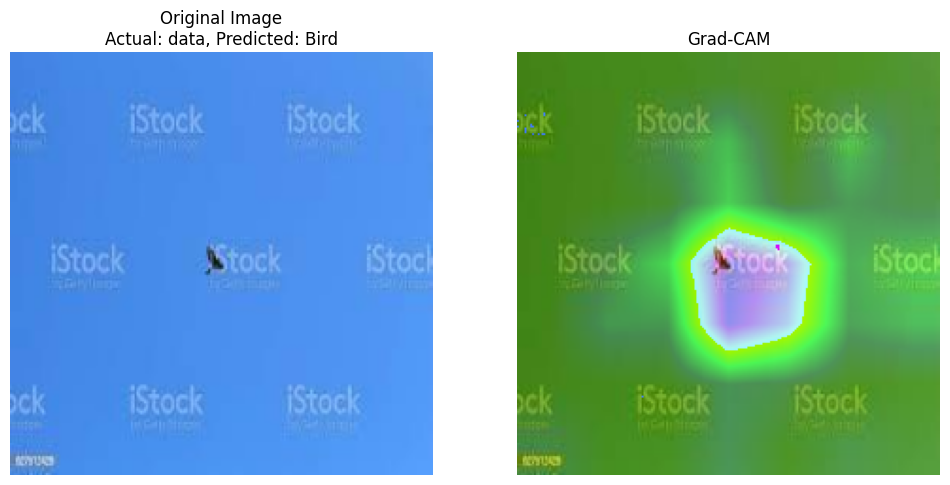

Actual Class: data
Predicted Class: Bird


In [17]:
# Grad-CAM Visualization
import tensorflow as tf
test_dir = TEST_PATH
class_names = list(test_generator.class_indices.keys())
image_paths = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        image_files = os.listdir(class_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(class_dir, image_file))
image_path = random.choice(image_paths)
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0
last_conv_layer = model.get_layer("conv5_block3_out") # You might need to experiment with different layers
grad_model = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
with tf.GradientTape() as tape:
    model_output, conv_layer_output = grad_model(img_array)
    class_index = np.argmax(model_output[0])
    grads = tape.gradient(model_output[0][class_index], conv_layer_output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1))
heatmap = np.zeros(conv_layer_output.shape[2])
for i in range(len(pooled_grads)):
    heatmap += pooled_grads[i] * conv_layer_output[0, :, :, i]
heatmap = K.relu(heatmap)
heatmap /= K.max(heatmap)
original_img = cv2.imread(image_path)
original_img = cv2.resize(original_img, (224, 224))
heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + original_img
actual_class = image_path.split('/')[-2]
predicted_class = class_names[class_index]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title(f'Original Image\nActual: {actual_class}, Predicted: {predicted_class}')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')
plt.show()
print(f'Actual Class: {actual_class}')
print(f'Predicted Class: {predicted_class}')
